# 【第1回_Beginner限定コンペ】銀行の顧客ターゲティング

顧客の属性情報などから定期預金キャンペーンの反応率を予測しよう。

https://signate.jp/competitions/292

CatBoost編

## ライブラリインポート

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import catboost

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_curve, auc

## データ読み込み・前処理

In [2]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

train_practice_df = pd.read_csv('train_practice.csv')
test_practice_df = pd.read_csv('test_practice.csv')

train_org_df = pd.read_csv('bank-full.csv', sep=';')

submit_df = pd.read_csv('submit_sample.csv', header=None)

In [3]:
print(train_df.shape)
print(test_df.shape)
print(train_practice_df.shape)
print(test_practice_df.shape)
print(train_org_df.shape)

(27100, 18)
(18050, 17)
(27128, 18)
(18083, 17)
(45211, 17)


In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27100 entries, 0 to 27099
Data columns (total 18 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         27100 non-null  int64 
 1   age        27100 non-null  int64 
 2   job        27100 non-null  object
 3   marital    27100 non-null  object
 4   education  27100 non-null  object
 5   default    27100 non-null  object
 6   balance    27100 non-null  int64 
 7   housing    27100 non-null  object
 8   loan       27100 non-null  object
 9   contact    27100 non-null  object
 10  day        27100 non-null  int64 
 11  month      27100 non-null  object
 12  duration   27100 non-null  int64 
 13  campaign   27100 non-null  int64 
 14  pdays      27100 non-null  int64 
 15  previous   27100 non-null  int64 
 16  poutcome   27100 non-null  object
 17  y          27100 non-null  int64 
dtypes: int64(9), object(9)
memory usage: 3.7+ MB


In [5]:
train_org_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


In [6]:
train_df['y'].value_counts()

0    24988
1     2112
Name: y, dtype: int64

In [7]:
train_org_df['y'].value_counts()

no     39922
yes     5289
Name: y, dtype: int64

In [8]:
train_df.head()

,id,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,0,31,services,married,secondary,no,12294,yes,no,cellular,21,nov,101,3,498,0,other,0
1,1,29,entrepreneur,single,tertiary,no,43027,no,no,cellular,22,aug,158,2,702,0,unknown,1
2,2,35,management,married,tertiary,no,12252,yes,no,cellular,11,nov,351,1,826,0,failure,0
3,3,31,technician,married,secondary,no,99121,yes,yes,unknown,16,may,658,2,120,0,failure,0
4,4,48,unemployed,married,primary,no,42005,yes,no,telephone,3,apr,177,1,273,0,unknown,0


In [9]:
train_org_df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [10]:
test_df.head()

,id,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome
0,0,35,technician,single,secondary,no,89043,no,no,cellular,7,feb,101,2,184,2,success
1,1,37,services,married,secondary,no,64372,yes,no,cellular,7,jul,158,3,241,0,unknown
2,2,31,services,single,secondary,no,31606,yes,no,unknown,15,may,152,2,47,0,unknown
3,3,31,admin.,married,secondary,no,94826,yes,no,cellular,27,may,345,2,490,0,unknown
4,4,32,services,married,secondary,no,100401,no,no,cellular,7,jan,126,1,686,0,other


In [11]:
train_df.describe()

,id,age,balance,day,duration,campaign,pdays,previous,y
count,27100.000000,27100.000000,27100.000000,27100.000000,27100.000000,27100.000000,27100.000000,27100.000000,27100.000000
mean,13549.500000,36.073284,47682.901771,16.700443,229.325387,1.775830,432.482399,0.085720,0.077934
std,7823.240484,7.816417,31650.760036,8.576252,204.939958,0.950045,252.150648,0.365889,0.268072
min,0.000000,22.000000,-6847.000000,1.000000,0.000000,1.000000,-1.000000,0.000000,0.000000
25%,6774.750000,31.000000,20015.750000,8.000000,121.000000,1.000000,214.000000,0.000000,0.000000
50%,13549.500000,33.000000,47624.000000,17.000000,158.000000,1.000000,432.000000,0.000000,0.000000
75%,20324.250000,37.000000,75330.000000,26.000000,345.000000,2.000000,650.000000,0.000000,0.000000
max,27099.000000,90.000000,102121.000000,31.000000,3076.000000,5.000000,870.000000,3.000000,1.000000


In [12]:
train_practice_df.describe()

,id,age,balance,day,duration,campaign,pdays,previous,y
count,27128.000000,27128.000000,27128.000000,27128.000000,27128.000000,27128.000000,27128.000000,27128.000000,27128.000000
mean,13564.500000,40.951010,1355.800870,15.806215,260.711295,2.751769,40.528052,0.579733,0.117001
std,7831.323388,10.608542,3003.305272,8.337904,260.091727,3.126594,100.382462,2.503653,0.321427
min,1.000000,18.000000,-6847.000000,1.000000,0.000000,1.000000,-1.000000,0.000000,0.000000
25%,6782.750000,33.000000,72.000000,8.000000,104.000000,1.000000,-1.000000,0.000000,0.000000
50%,13564.500000,39.000000,449.000000,16.000000,182.000000,2.000000,-1.000000,0.000000,0.000000
75%,20346.250000,48.000000,1428.000000,21.000000,323.000000,3.000000,-1.000000,0.000000,0.000000
max,27128.000000,95.000000,102127.000000,31.000000,4918.000000,63.000000,871.000000,275.000000,1.000000


In [13]:
test_df.describe()

,id,age,balance,day,duration,campaign,pdays,previous
count,18050.000000,18050.000000,18050.000000,18050.000000,18050.000000,18050.000000,18050.000000,18050.000000
mean,9024.500000,36.104266,47158.451801,16.697950,229.315014,1.770083,436.171801,0.090859
std,5210.730515,7.863805,31469.525699,8.580203,208.796946,0.944872,251.392519,0.375801
min,0.000000,20.000000,-6838.000000,1.000000,0.000000,1.000000,-1.000000,0.000000
25%,4512.250000,31.000000,19654.500000,8.000000,121.000000,1.000000,219.250000,0.000000
50%,9024.500000,33.000000,46886.000000,17.000000,158.000000,1.000000,436.000000,0.000000
75%,13536.750000,37.000000,74178.000000,26.000000,345.000000,2.000000,654.000000,0.000000
max,18049.000000,90.000000,102124.000000,31.000000,3076.000000,4.000000,870.000000,3.000000


In [14]:
train_df.isnull().any()

id           False
age          False
job          False
marital      False
education    False
default      False
balance      False
housing      False
loan         False
contact      False
day          False
month        False
duration     False
campaign     False
pdays        False
previous     False
poutcome     False
y            False
dtype: bool

In [15]:
train_org_df.isnull().any()

age          False
job          False
marital      False
education    False
default      False
balance      False
housing      False
loan         False
contact      False
day          False
month        False
duration     False
campaign     False
pdays        False
previous     False
poutcome     False
y            False
dtype: bool

In [16]:
test_df.isnull().any()

id           False
age          False
job          False
marital      False
education    False
default      False
balance      False
housing      False
loan         False
contact      False
day          False
month        False
duration     False
campaign     False
pdays        False
previous     False
poutcome     False
dtype: bool

In [17]:
# job のラベリングを y の平均の低い順にしてみる
#train_df.groupby('job').mean().sort_values('y')

In [18]:
train_df.drop(['id'], axis=1, inplace=True)
test_df.drop(['id'], axis=1, inplace=True)

train_org_df['y'] = train_org_df['y'].map(dict(yes=1, no=0))

#train_df = pd.concat([train_df, train_org_df])
train_df.shape

(27100, 17)

データメモ

- testデータの `job` に `unknown` が一人いる (trainデータにはいない)

In [19]:
train_df['y'].value_counts()

0    24988
1     2112
Name: y, dtype: int64

In [20]:
xx_range = np.arange(0, 401, 50)
#xx_label_mean = train_df.groupby('pdays')['y'].mean()
xx_label_mean = train_df.groupby(pd.cut(train_df['pdays'], xx_range))['y'].mean()
xx_label_mean

pdays
(0, 50]       0.081905
(50, 100]     0.076582
(100, 150]    0.070131
(150, 200]    0.079479
(200, 250]    0.087452
(250, 300]    0.073186
(300, 350]    0.077223
(350, 400]    0.081011
Name: y, dtype: float64

In [21]:
train_df.groupby(pd.cut(train_df['pdays'], xx_range))['y'].size()

pdays
(0, 50]       1575
(50, 100]     1580
(100, 150]    1597
(150, 200]    1535
(200, 250]    1578
(250, 300]    1585
(300, 350]    1541
(350, 400]    1543
Name: y, dtype: int64

In [22]:
# one hot encoding
#train_df = pd.get_dummies(train_df, columns=['job', 'marital', 'education', 'contact', 'poutcome'])
#test_df = pd.get_dummies(test_df, columns=['job', 'marital', 'education', 'contact', 'poutcome'])
#test_df.drop(['job_unknown'], axis=1, inplace=True)

df_list = [train_df, test_df, train_org_df]

#train_df['poutcome'] = (train_df['poutcome'] + train2_df['poutcome'] + train3_df['poutcome']) / 3
#test_df['poutcome'] = (test_df['poutcome'] + test2_df['poutcome'] + test3_df['poutcome']) / 3

#job_encoder = LabelEncoder()
#job_encoder.fit(test_df['job'])

for df in df_list:
    # Target Mean Encoding
    #df['job_label_mean'] = df['job'].map(job_label_mean)
    #df.drop(['job'], axis=1, inplace=True)
    
    #df['job'] = job_encoder.transform(df['job'])
    df['job'] = df['job'].map({'unknown': 1, 'technician': 2, 'blue-collar': 3, 'services': 4, 'entrepreneur': 5, 'admin.': 6, 'management': 7, 'housemaid': 8, 'self-employed': 9, 'unemployed': 10, 'retired': 11, 'student': 12})
    
    df['marital'] = df['marital'].map({'married': 2, 'divorced':1, 'single': 0})
    #df.drop(['marital'], axis=1, inplace=True)

    df['education'] = df['education'].map({'tertiary': 3, 'secondary': 2, 'primary': 1, 'unknown': 0})
    #df.drop(['education'], axis=1, inplace=True)

    #df['default'] = df['default'].map({'yes': 1, 'no': 0})
    df.drop(['default'], axis=1, inplace=True)

    df['housing'] = df['housing'].map({'yes': 1, 'no': 0})
    #df.drop(['housing'], axis=1, inplace=True)
    
    df['loan'] = df['loan'].map({'yes': 1, 'no': 0})
    #df.drop(['loan'], axis=1, inplace=True)

    df['contact'] = df['contact'].map({'telephone': 2, 'cellular': 1, 'unknown': 0})
    #df.drop(['contact'], axis=1, inplace=True)

    df['poutcome'] = df['poutcome'].map({'success': 3, 'unknown': 2, 'failure': 1, 'other': 0})
    #df['p_label_mean'] = np.log(df['poutcome'].map(p_label_mean))
    #df.drop(['poutcome'], axis=1, inplace=True)
    
    df['month'] = df['month'].map({'jan': 1, 'feb': 2, 'mar': 3, 'apr': 4, 'may': 5, 'jun': 6, 'jul': 7, 'aug': 8, 'sep': 9, 'oct': 10, 'nov': 11, 'dec': 12})
    #df.drop(['day', 'month'], axis=1, inplace=True)
    
    # Feb 30 とかあって、正確には変換できない
    # → データの Feb 30 を Mar 1 に変換した(他にも、 2/31, 6/31, 11/31)
    df['days'] = pd.to_datetime('2016/' + df['month'].astype(str).str.pad(2,fillchar='0') + '/' + df['day'].astype(str).str.pad(2,fillchar='0'), format='%Y/%m/%d').dt.strftime('%j').astype('uint16')
    #df['days'] = df['month'] * 31 + df['day']

    #df['duration'] = np.log(df['duration'] + 1)
    #df['bpp'] = np.log((df['balance'] - df['balance'].min()) / (df['pdays'] + 2) + 1)
    
    #df.drop(['id'], axis=1, inplace=True)
    
    df['cdp'] = (df['campaign'] - df['previous']) * df['duration']
    
    df.drop(['pdays'], axis=1, inplace=True)
    df.drop(['balance'], axis=1, inplace=True)
    
# featuretools用
#y = train_df.pop('y')
#train_df['train'] = 1
#test_df['train'] = 0
#test_df['id'] = test_df['id'] + len(train_df)

In [23]:
#xx_range = np.arange(0, 351, 50)
xx_range = np.array([0, 250, 500, 3100])
#xx_label_mean = train_df.groupby('days')['y'].mean()
xx_label_mean = train_df.groupby(pd.cut(train_df['duration'], xx_range))['y'].mean()
xx_label_mean

duration
(0, 250]       0.094956
(250, 500]     0.015524
(500, 3100]    0.114133
Name: y, dtype: float64

In [24]:
for df in df_list:
    pass
    #df['xx_label_mean'] = df['duration'].map(xx_label_mean)

In [25]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27100 entries, 0 to 27099
Data columns (total 16 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        27100 non-null  int64 
 1   job        27100 non-null  int64 
 2   marital    27100 non-null  int64 
 3   education  27100 non-null  int64 
 4   housing    27100 non-null  int64 
 5   loan       27100 non-null  int64 
 6   contact    27100 non-null  int64 
 7   day        27100 non-null  int64 
 8   month      27100 non-null  int64 
 9   duration   27100 non-null  int64 
 10  campaign   27100 non-null  int64 
 11  previous   27100 non-null  int64 
 12  poutcome   27100 non-null  int64 
 13  y          27100 non-null  int64 
 14  days       27100 non-null  uint16
 15  cdp        27100 non-null  int64 
dtypes: int64(15), uint16(1)
memory usage: 3.2 MB


In [26]:
train_df.head()

,age,job,marital,education,housing,loan,contact,day,month,duration,campaign,previous,poutcome,y,days,cdp
0,31,4,2,2,1,0,1,21,11,101,3,0,0,0,326,303
1,29,5,0,3,0,0,1,22,8,158,2,0,2,1,235,316
2,35,7,2,3,1,0,1,11,11,351,1,0,1,0,316,351
3,31,2,2,2,1,1,0,16,5,658,2,0,1,0,137,1316
4,48,10,2,1,1,0,2,3,4,177,1,0,2,0,94,177


In [27]:
test_df.head()

,age,job,marital,education,housing,loan,contact,day,month,duration,campaign,previous,poutcome,days,cdp
0,35,2,0,2,0,0,1,7,2,101,2,2,3,38,0
1,37,4,2,2,1,0,1,7,7,158,3,0,2,189,474
2,31,4,0,2,1,0,0,15,5,152,2,0,2,136,304
3,31,6,2,2,1,0,1,27,5,345,2,0,2,148,690
4,32,4,2,2,0,0,1,7,1,126,1,0,0,7,126


In [28]:
train_df.describe()

,age,job,marital,education,housing,loan,contact,day,month,duration,campaign,previous,poutcome,y,days,cdp
count,27100.000000,27100.000000,27100.000000,27100.000000,27100.000000,27100.000000,27100.000000,27100.000000,27100.000000,27100.000000,27100.000000,27100.000000,27100.000000,27100.000000,27100.000000,27100.000000
mean,36.073284,5.152509,1.386162,2.046125,0.583727,0.127269,0.788007,16.700443,6.003542,229.325387,1.775830,0.085720,1.855683,0.077934,168.623579,370.297269
std,7.816417,2.669990,0.872384,0.727044,0.492949,0.333281,0.498535,8.576252,2.135158,204.939958,0.950045,0.365889,0.467181,0.268072,65.155774,405.680999
min,22.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,3.000000,-2674.000000
25%,31.000000,3.000000,0.000000,2.000000,0.000000,0.000000,0.000000,8.000000,5.000000,121.000000,1.000000,0.000000,2.000000,0.000000,136.000000,152.000000
50%,33.000000,5.000000,2.000000,2.000000,1.000000,0.000000,1.000000,17.000000,5.000000,158.000000,1.000000,0.000000,2.000000,0.000000,148.000000,304.000000
75%,37.000000,7.000000,2.000000,2.000000,1.000000,0.000000,1.000000,26.000000,7.000000,345.000000,2.000000,0.000000,2.000000,0.000000,199.000000,456.000000
max,90.000000,12.000000,2.000000,3.000000,1.000000,1.000000,2.000000,31.000000,12.000000,3076.000000,5.000000,3.000000,3.000000,1.000000,336.000000,9228.000000


In [29]:
test_df.describe()

,age,job,marital,education,housing,loan,contact,day,month,duration,campaign,previous,poutcome,days,cdp
count,18050.000000,18050.000000,18050.000000,18050.000000,18050.000000,18050.000000,18050.000000,18050.000000,18050.000000,18050.000000,18050.000000,18050.000000,18050.000000,18050.000000,18050.000000
mean,36.104266,5.120388,1.382161,2.039501,0.577175,0.128587,0.783989,16.697950,5.998726,229.315014,1.770083,0.090859,1.858061,168.471468,371.912299
std,7.863805,2.650421,0.873514,0.717774,0.494022,0.334752,0.504881,8.580203,2.118452,208.796946,0.944872,0.375801,0.464028,64.614438,436.815067
min,20.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,3.000000,-2054.000000
25%,31.000000,3.000000,0.000000,2.000000,0.000000,0.000000,0.000000,8.000000,5.000000,121.000000,1.000000,0.000000,2.000000,136.000000,152.000000
50%,33.000000,5.000000,2.000000,2.000000,1.000000,0.000000,1.000000,17.000000,5.000000,158.000000,1.000000,0.000000,2.000000,148.000000,304.000000
75%,37.000000,7.000000,2.000000,2.000000,1.000000,0.000000,1.000000,26.000000,7.000000,345.000000,2.000000,0.000000,2.000000,199.000000,456.000000
max,90.000000,12.000000,2.000000,3.000000,1.000000,1.000000,2.000000,31.000000,12.000000,3076.000000,4.000000,3.000000,3.000000,336.000000,12304.000000


## 学習準備

In [38]:
y = train_df.pop('y')

# null importance
#y = np.random.permutation(y)

X_train, X_test, y_train, y_test = train_test_split(train_df, y, test_size=0.2, random_state=22)

train_data = catboost.Pool(X_train, label=y_train)
test_data = catboost.Pool(X_test, label=y_test)
final_train_set = catboost.Pool(train_df, label=y)

## ハイパーパラメータ

In [2]:
# WIP

params = {
    'application': 'binary',     # Binary classification
    'custom_metric': 'AUC',  # Area under ROC curve as the evaulation metric
    # 以下はoptunaでチューニングする
    'num_boost_round': 10000,
    'learning_rate': 0.01,       # Learning rate, controls size of a gradient descent step
    'min_data_in_leaf': 20,      # Data set is quite small so reduce this a bit
    'feature_fraction': 0.7,     # Proportion of features in each boost, controls overfitting
    'num_leaves': 41,            # Controls size of tree since LGBM uses leaf wise splits
    'drop_rate': 0.15,
    'random_seed': 22
}

## 学習

In [40]:
evaluation_results = {}

clf = lgb.train(
    train_set=train_data,
    params=lgb_params,
    valid_sets=[train_data, test_data], 
    valid_names=['Train', 'Test'],
    evals_result=evaluation_results,
    num_boost_round=10000,
    early_stopping_rounds=100,
    verbose_eval=100
)
optimum_boost_rounds = clf.best_iteration

print('Result:')
print(clf.params)
print(clf.best_score)

Training until validation scores don't improve for 100 rounds
[100]	Train's auc: 0.873929	Test's auc: 0.837195
[200]	Train's auc: 0.889406	Test's auc: 0.842798
[300]	Train's auc: 0.902438	Test's auc: 0.847498
[400]	Train's auc: 0.913196	Test's auc: 0.851462
[500]	Train's auc: 0.921679	Test's auc: 0.852661
[600]	Train's auc: 0.928849	Test's auc: 0.853849
[700]	Train's auc: 0.935118	Test's auc: 0.854065
[800]	Train's auc: 0.940275	Test's auc: 0.853638
Early stopping, best iteration is:
[707]	Train's auc: 0.935517	Test's auc: 0.85417
Result:
{'application': 'binary', 'metric': 'auc', 'learning_rate': 0.01, 'min_data_in_leaf': 20, 'feature_fraction': 0.7, 'num_leaves': 41, 'drop_rate': 0.15, 'random_state': 22}
defaultdict(<class 'collections.OrderedDict'>, {'Train': OrderedDict([('auc', 0.9355170766932484)]), 'Test': OrderedDict([('auc', 0.8541704109753175)])})


## 可視化

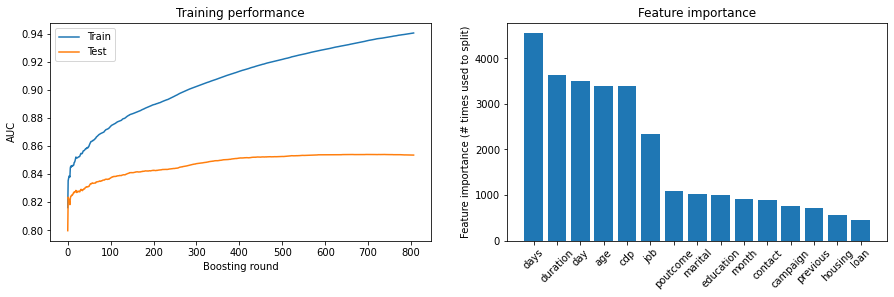

In [41]:
fig, axs = plt.subplots(1, 2, figsize=[15, 4])

# Plot the log loss during training
axs[0].plot(evaluation_results['Train']['auc'], label='Train')
axs[0].plot(evaluation_results['Test']['auc'], label='Test')
axs[0].set_ylabel('AUC')
axs[0].set_xlabel('Boosting round')
axs[0].set_title('Training performance')
axs[0].legend()

# Plot feature importance
importances = pd.DataFrame({'features': clf.feature_name(), 
                            'importance': clf.feature_importance()}).sort_values('importance', ascending=False)
axs[1].bar(x=np.arange(len(importances)), height=importances['importance'])
axs[1].set_xticks(np.arange(len(importances)))
axs[1].set_xticklabels(importances['features'], rotation = 45)
axs[1].set_ylabel('Feature importance (# times used to split)')
axs[1].set_title('Feature importance')

plt.show()

In [42]:
importances.sort_values('importance')

,features,importance
5,loan,460
4,housing,572
11,previous,709
10,campaign,765
6,contact,896
8,month,913
3,education,1011
2,marital,1017
12,poutcome,1091
1,job,2344


In [43]:
preds = np.round(clf.predict(X_test))

print('Accuracy score = \t {}'.format(accuracy_score(y_test, preds)))
print('Precision score = \t {}'.format(precision_score(y_test, preds)))
print('Recall score =   \t {}'.format(recall_score(y_test, preds)))
print('F1 score =      \t {}'.format(f1_score(y_test, preds)))

Accuracy score = 	 0.9350553505535055
Precision score = 	 0.7753623188405797
Recall score =   	 0.25
F1 score =      	 0.37809187279151946


In [44]:
fpr, tpr, thresholds = roc_curve(y_test, preds)
auc_score = auc(fpr, tpr)
print(auc_score)

0.621895032051282


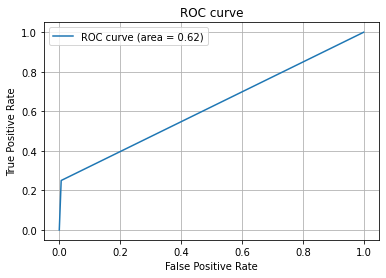

In [45]:
# ROC曲線をプロット
plt.plot(fpr, tpr, label='ROC curve (area = %.2f)'%auc_score)
plt.legend()
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)

## 推論

In [46]:
test_pred = clf.predict(test_df, num_iteration=optimum_boost_rounds)

In [47]:
submit_df[1] = test_pred
submit_df.to_csv('submit.csv', header=False, index=False)

In [48]:
#pseudo labeling

#test_df['y'] = test_pred
#test_df.to_csv('test_p1.csv', index=False)

In [49]:
train_df['y'] = y
test_df['y'] = np.round(test_pred)

In [ ]:
train_df_eda_pg = sns.pairplot(train_df, hue='y')
train_df_eda_pg.savefig('train_df_eda.png')

In [ ]:
test_df_eda_pg = sns.pairplot(test_df, hue='y')
test_df_eda_pg.savefig('test_df_eda.png')